# LIBRARY

In [2]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import clone


from sklearn.decomposition import PCA

import xgboost as xgb
from datetime import timedelta, datetime, date

#import lazypredict
#from lazypredict.Supervised import LazyRegressor
#from catboost import CatBoostRegressor

#from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics import accuracy_score
from tqdm import tqdm
# from tqdm import tnrange

# SETUP

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

VERSION    = 16
VAL_SIZE   = 0.20   # 20%
RANDOM_SEED = 42

x_size = 8
y_size = 5

# FUNCTIONS

In [4]:
def mape(y_true, y_pred):
    """функция целевой метрики"""
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
def getCountPlot(df, feature, x_s=x_size, y_s=y_size):
    """строим график распределения признака"""
    plt.figure(figsize=(x_s, y_s))
    sns.countplot(data=df,
            order = df[feature].value_counts().index, 
            y=feature)
    plt.title(f'Распределение значений признака {feature}')
    plt.show;

In [6]:
def interquartile_range(series, x_s=x_size, y_s=y_size, bins=50):
    '''
    Вычисляет межквартильный размах в серии
    series - Pandas Series
    x_s (int) - размер оси x
    y_s (int) - размер оси y
    bins (int) - количество столбцов гистограммы
    '''
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25, perc75 = series.quantile(0.25), series.quantile(0.75)
    f, l = perc25 - 1.5*IQR, perc75 + 1.5*IQR

    title = f'25-й перцентиль: {perc25}, \
    75-й перцентиль: {perc75},\nIQR: {IQR}, границы выбросов: [{f}, {l}]'

    plt.figure(figsize=(x_s, y_s))
    sns.histplot(data=series.loc[series.between(perc25 - 1.5*IQR,
                                                perc75 + 1.5*IQR)], bins=bins)
    plt.title(f'IQR\n{title}');

In [7]:
def replace_outliers(val, low, high):
    """ функция для обработки выбрасов
    val = значение
    low = q_1 - IQR * 1.5
    high = q_3 + IQR * 1.5 """
    
    if val < low:
        return low
    
    elif val > high:
        return high
    
    else:
        return val

# DATA

In [8]:
train = pd.read_csv(r'parsing_auto_ru.csv', sep='\t', low_memory = False)  # датасет для обучения модели
test = pd.read_csv(r'test.csv')
sample_submission = pd.read_csv(r'sample_submission.csv')

In [9]:
display(f'train {train.shape}, test {test.shape}, sample_submission {sample_submission.shape}')

'train (113327, 33), test (34686, 32), sample_submission (34686, 2)'

## Целевая переменная - price

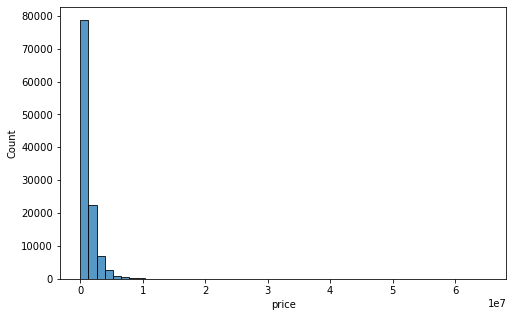

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(data=train['price'], bins=50);

Видно, что есть небольшое количество очень низких цен. В результате выборочной проверки нескольких ссылок выяснилось, что это ошибка при сборе данных - эти автомобили уже были проданы. Можно удалить эти экстремальные данные 

In [11]:
train.price.value_counts().sort_index()

0.50           373
0.85           104
1.00            25
3999.00         74
12000.00         1
              ... 
29000000.00      1
29800000.00      1
30850000.00      1
62500000.00      1
65000000.00      1
Name: price, Length: 7419, dtype: int64

* Цены меньше 3999 - явная ошибка при сборе данных
* Цена 3999 - 74 автомобиля по такой цене - тоже ошибка (выборочная проверка показала, что автомобили уже проданы)
* за 12 тысяч продаётся реальный [автомобиль](https://auto.ru/cars/used/sale/nissan/bluebird/1104156088-92a6cd31/)

Т.о. удаляем строки с ценами меньше 12000

In [12]:
train = train.query("price >= 12000").reset_index(drop=True)

## Первичный осмотр

In [13]:
# осмотрим тестовые и тренеровочные данные:
for i in [train, test]:
    print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112751 entries, 0 to 112750
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              112751 non-null  object 
 1   brand                 112751 non-null  object 
 2   car_url               112751 non-null  object 
 3   color                 112751 non-null  object 
 4   complectation_dict    16972 non-null   object 
 5   description           112724 non-null  object 
 6   engineDisplacement    112751 non-null  object 
 7   enginePower           112751 non-null  object 
 8   equipment_dict        73347 non-null   object 
 9   fuelType              112751 non-null  object 
 10  image                 108758 non-null  object 
 11  mileage               112751 non-null  int64  
 12  modelDate             112751 non-null  int64  
 13  model_info            112751 non-null  object 
 14  model_name            112751 non-null  object 
 15  

In [14]:
# отметим тренировочный и тестовый
train['sample'] = 1
test['sample'] = 0
# соединим их вместе
data = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [15]:
# осмотрим рабочие данные
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147437 entries, 0 to 147436
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              147437 non-null  object 
 1   brand                 147437 non-null  object 
 2   car_url               147437 non-null  object 
 3   color                 147437 non-null  object 
 4   complectation_dict    23390 non-null   object 
 5   description           147410 non-null  object 
 6   engineDisplacement    147437 non-null  object 
 7   enginePower           147437 non-null  object 
 8   equipment_dict        98037 non-null   object 
 9   fuelType              147437 non-null  object 
 10  image                 143444 non-null  object 
 11  mileage               147437 non-null  int64  
 12  modelDate             147437 non-null  int64  
 13  model_info            147437 non-null  object 
 14  model_name            147437 non-null  object 
 15  

## Описание полей


1. bodyType - тип кузова
1. brand - бренд автомобиля
1. car_url - ссылка на объявление, уникальные
1. color - цвет
1. complectation_dict - описание комплектации (словарь)
1. description - описание автомобиля продавцом
1. engineDisplacement - объём двигателя
1. enginePower - мощность двигателя
1. equipment_dict - оснащенность автомобиля опциями
1. fuelType - тип топлива
1. image - фото
1. mileage - пробег
1. modelDate - год начала выпуска этой модели автомобиля 
1. model_info - общая информация об автомобиле (марка, модель, правила склонения в русском языке и т.д)
1. model_name - название модели латиницей
1. name - часть технического описания автомобиля, состоит из объёма двигателя, типа КПП и мощности двигателя
1. numberOfDoors - количество дверей
1. parsing_unixtime - время парсинга
1. priceCurrency - валюта "RUB" Constant
1. productionDate - год выпуска этого автомобиля
1. sell_id id объявления
1. super_gen - словарь с величинами технических признаков (клиренс, разгон до 100 км/ч, расход топлива и т.д)
1. vehicleConfiguration - Конфигурация автомобиля, составной признак (тип кузова, КПП, мощность двигателя)
1. vehicleTransmission - тип КПП
1. vendor - для какого рынка выпущен автомобиль (Европа, Азия, Америка)
1. Владельцы - количество прошлых владельцев автомобиля
1. Владение - длительность владения автомобилем продавцом
1. ПТС - оригинал/дубликат
1. Привод - тип привода (передний, задний, полный)
1. Руль - левый/правый
1. Состояние - если авто требует ремонта - нет метки, есл не требует - значение "Не требует ремонта"
1. Таможня - "Растаможен"	Constant
1. price - цена 



















## Уникальность строк

В датасете есть как минимум 2 признака, которые должны содержать уникальные значения
* sell_id
* car_url


In [16]:
#  Проверим на уникальность всех id - есть не уникальные
len(data) == data.sell_id.nunique()

False

In [17]:
# удалим дубликаты из train
data.drop_duplicates(subset=['sell_id'], keep='last',inplace=True)

In [18]:
# проверим на nan в sell_id  - отсутствуют
len(data.sell_id) - data.sell_id.count()

0

## Пропуски данных

In [19]:
# проверим на наличие пропусков
print(f'Всего пропущенных данных {data.isna().sum().sum()}')

Всего пропущенных данных 315692


In [20]:
data.isna().sum()

bodyType                     0
brand                        0
car_url                      0
color                        0
complectation_dict      123112
description                 27
engineDisplacement           0
enginePower                  0
equipment_dict           49030
fuelType                     0
image                     3985
mileage                      0
modelDate                    0
model_info                   0
model_name                   0
name                         0
numberOfDoors                0
parsing_unixtime             0
priceCurrency                0
productionDate               0
sell_id                      0
super_gen                    0
vehicleConfiguration         0
vehicleTransmission          0
vendor                      52
Владельцы                    0
Владение                101903
ПТС                          1
Привод                       0
Руль                         0
Состояние                 2896
Таможня                      0
price   

Очень много пропусков содержат:
* complectation_dict
* equipment_dict

И хотя они очень содержательны (описывают технические характеристики автомобиля в очень широком спектре), от них придётся отказаться.
Возможно стоит (в качестве эксперимента) в дальнейшем сапарсить данные, содержащие equipment_dict, добаввить их в датасет и обработать этот признак (например векторизовать)

* Владение - тоже исключаем

* description - можно удалить всесь признак, так как в значения попали не только описания владельцев, но и общий рекламный текст (ошибка при парсинге)

* image - без фото как правило объявления о битых машинах, удаляем этот признак.

* vendor - можно заполнить пропуски наиболее частым значением

* ПТС - тоже заполнить самым частым

* Состояние - необходимо пропуски заполнить значением "Требует ремонта"

* model_info - дублирует имеющиеся признаки - удалить


In [21]:
# Удалим признаки, содержащие слишком большое число пропусков или те, которые точно не нужны
data.drop(['complectation_dict', 'equipment_dict','image', 'Владение','Таможня',
           'priceCurrency','model_info'], axis=1, inplace=True)


* priceCurrency - валюта везде одна
* Таможня - все значения "Растаможен"


Заполним пропуски в vendor, ПТС и Состояние



In [22]:
# Заменяем самым частым значением
for i in ['vendor','ПТС']:
    top = data[i].describe()['top']
    data[i] = data[i].fillna(top)

# Следуя логике - это бинарный признак
data['Состояние'] = data['Состояние'] .fillna('Требует ремонта')

Удалим оставшиеся пустые значения в description                 

In [23]:
data.dropna(subset=['description'], inplace=True)

Проверим - остались ли пропуски в данных

In [24]:
print(f'Всего пропущенных данных {data.isna().sum().sum()}')

Всего пропущенных данных 34686


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146296 entries, 0 to 147436
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              146296 non-null  object 
 1   brand                 146296 non-null  object 
 2   car_url               146296 non-null  object 
 3   color                 146296 non-null  object 
 4   description           146296 non-null  object 
 5   engineDisplacement    146296 non-null  object 
 6   enginePower           146296 non-null  object 
 7   fuelType              146296 non-null  object 
 8   mileage               146296 non-null  int64  
 9   modelDate             146296 non-null  int64  
 10  model_name            146296 non-null  object 
 11  name                  146296 non-null  object 
 12  numberOfDoors         146296 non-null  int64  
 13  parsing_unixtime      146296 non-null  int64  
 14  productionDate        146296 non-null  int64  
 15  

# NAIVE MODEL

Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). 
C ней будем сравнивать другие модели.

In [26]:
# снова выделим train и test из подготовленных на этом этапе данных
train = data[data['sample'] == 1].copy()
test = data[data['sample'] == 0].copy()

# для baseline просто возьму пару схожих признаков без полной обработки
columns = ['bodyType','brand','color','engineDisplacement','enginePower',
            'fuelType','model_name','name','numberOfDoors','productionDate',
            'vehicleConfiguration','vehicleTransmission','Владельцы',
            'Привод','Руль']


df_train = train[columns].copy()
df_test = test[columns].copy()
y = train['price']

### Label Encoding

In [27]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_naiv = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [28]:
df_naiv.sample()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,model_name,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,Владельцы,Привод,Руль,sample
87150,седан,AUDI,серебристый,1.8 LTR,160 N12,бензин,A4,1.8 CVT (160 л.с.),4,2011,SEDAN VARIATOR 1.8,вариатор,3 или более,передний,Левый,1


In [29]:
for colum in ['bodyType', 'brand', 'color', 'engineDisplacement']:
    df_naiv[colum] = df_naiv[colum].astype('category').cat.codes

In [30]:
X = df_naiv.query('sample == 1').drop(['sample'], axis=1)
X_sub = df_naiv.query('sample == 0').drop(['sample'], axis=1)

### Train Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [32]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [33]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 138.04%


# EDA

## PANDAS PROFILING

html доступен по ссылке

[report.html](https://drive.google.com/file/d/1FQpFLa1_nhmWpQqQdFsRrj5RVkcBMUCu/view?usp=sharing)



In [34]:
# profile = ProfileReport(data, title="Pandas Profiling Report")
# profile.to_notebook_iframe() # развёрнутый вид
# profile.to_file("report.html") # в файл

## Категориальные признаки

### bodyType

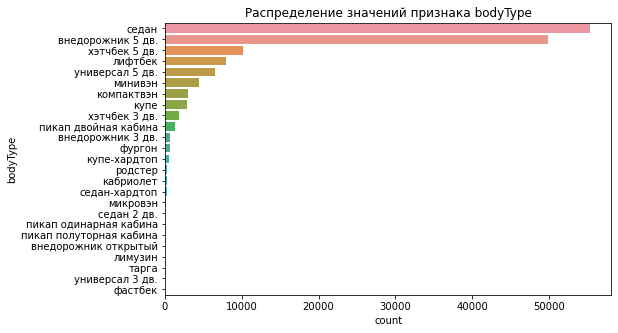

In [35]:
getCountPlot(data,'bodyType')

### brand

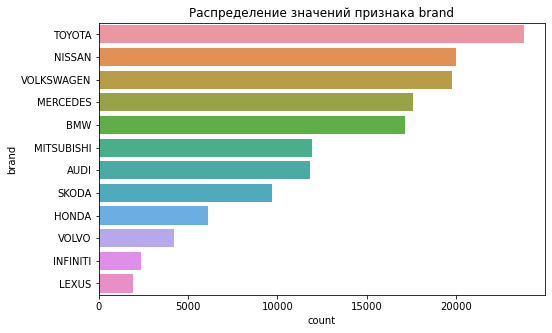

In [36]:
getCountPlot (data,'brand')

###  color

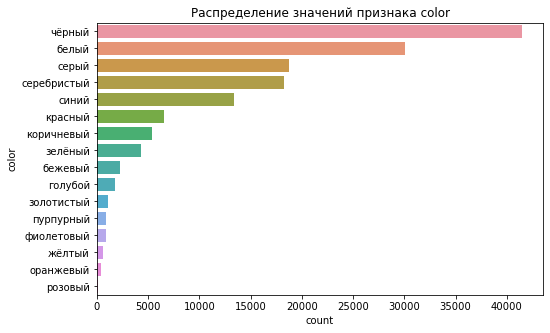

In [37]:
getCountPlot(data,'color')

### description

In [38]:
data.description

0         Продаю свою авоську, автомобиль полностью обсл...
1         Авто в идеальном состоянии, по техническому со...
2         Авто в отличном тех состоянии, установлено ГБО...
3         Продам Volkswagen passat b6 в хорошем состояни...
4         ПТС таможенный, за все время один собственник!...
                                ...                        
147432    Продается BMW 316i в отличном состоянии. Прода...
147433                       Продаётся отличный автомобиль.
147434                                    Хорошее состояние
147435    Автомобиль в идеальном состоянии . Куплен новы...
147436     Пробег реальный, состояние отличное! Авторска...
Name: description, Length: 146296, dtype: object

Это описание автомобиля, сделанное владельцем.
Есть как минимум 2 пути - векторизовать признак или простой - создать на его основе признак description_len, содержащий длинну текста (исходим из предположения, что чем подробнее описание, тем большую стоимость продавец хочет выручить, а значит должна быть зависимость).

In [39]:
#  Создадим новый числовой признак
data['description_len'] = data['description'].apply(lambda x: len(str(x)))

In [40]:
# удаляем
data.drop(['description'], axis=1, inplace=True)

In [41]:
# посмотрим на новый признак
data.description_len.describe()

count    146296.000000
mean        611.271990
std         748.317263
min           1.000000
25%         149.000000
50%         336.000000
75%         811.000000
max       29938.000000
Name: description_len, dtype: float64

Очевидно, что поля с описанием содержали аномальные значения - минимальная длина текста 1, масимальная почти 3 тысячи. Это очевидные ошибки

In [42]:
data.description_len.value_counts().sort_index()

1        134
2         12
3         63
4         96
5         73
        ... 
12911      1
13320      1
17468      1
28789      1
29938      1
Name: description_len, Length: 4364, dtype: int64

За образец возьмем тестовый датафрейм

In [43]:
mn = data[data['sample'] == 0]['description_len'].min()
mx = data[data['sample'] == 0]['description_len'].max()
data = data.query('description_len >= @mn & description_len <= @mx').reset_index(drop=True)

Мы создали этот признак из описания - он должен отражать длинну текста описания.
Возможно текст не везде был адекватный, в таком случае в этом признаке мы увидим аномалии распределения

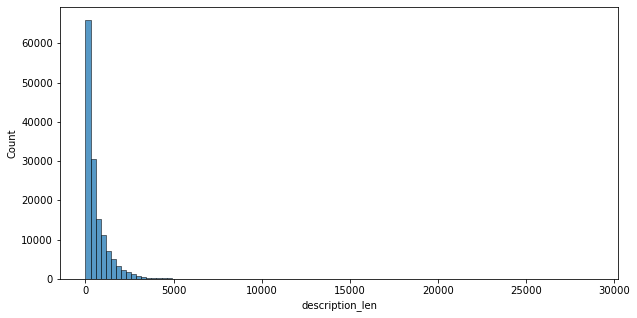

In [44]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['description_len'], bins=100); #, log_scale=True

Видим, что есть выбросы

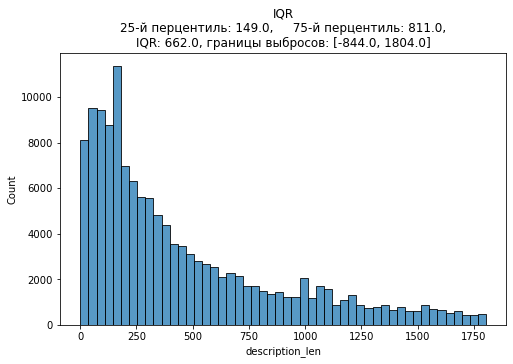

In [45]:
interquartile_range(data['description_len'], bins=50)

In [46]:
# обработаем выбросы

q_1 = np.quantile(data['description_len'], 0.25) 
q_3 = np.quantile(data['description_len'], 0.75) 
IQR = q_3 - q_1
low = q_1 - IQR * 1.5 
high = q_3 + IQR * 1.5
data['description_len'] = data['description_len'].map(lambda x: replace_outliers(x, low, high))

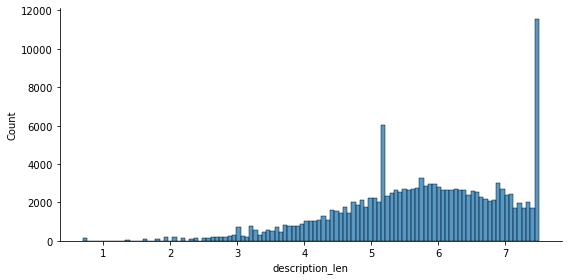

In [47]:
# логарифмируем
data['description_len'] = data['description_len'].apply(lambda w: np.log(w + 1))
sns.displot(data=data, x="description_len", height=4, aspect=2);

### engineDisplacement

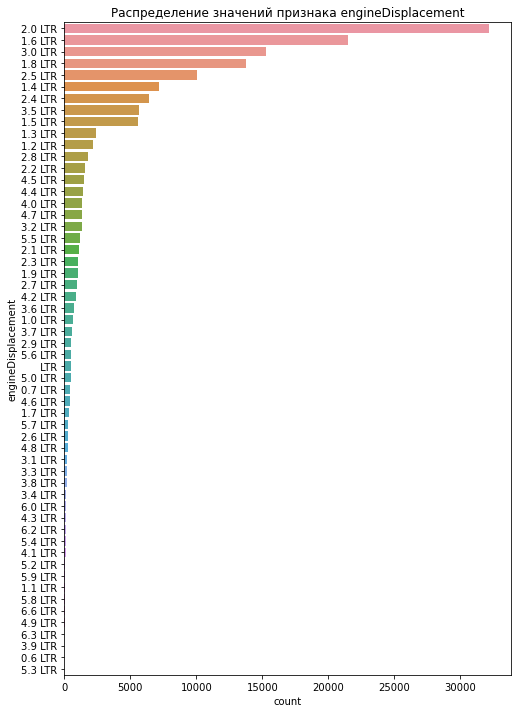

In [48]:
getCountPlot(data,'engineDisplacement',8,12)

Есть значение признака без указания объёма двигателя:

In [49]:
data[data['engineDisplacement']==' LTR'].groupby(['brand',
                                                  'model_name',
                                                  'fuelType'])['sell_id'].count()

brand       model_name        fuelType
AUDI        E_TRON            электро      13
            E_TRON_GT         электро       1
            E_TRON_S          электро       1
            E_TRON_SPORTBACK  электро       1
            RS_E_TRON_GT      электро       2
BMW         I3                электро      55
MERCEDES    B_KLASSE          электро       3
            EQC               электро       6
            EQV               электро       5
MITSUBISHI  I_MIEV            электро      11
            MINICAB           электро       6
NISSAN      BLUEBIRD_SYLPHY   электро       1
            LEAF              электро     409
            NV200             электро       4
TOYOTA      COMS              электро       1
            RAV_4             электро       2
VOLKSWAGEN  GOLF              электро       9
Name: sell_id, dtype: int64

Это электромобили

In [50]:
# очистим признак от ненужных букв и заменим пустые значения в электрокарах на 0

data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: 0 if x==' LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].astype(str).apply(lambda x: x.split()[0])
data['engineDisplacement'] = data['engineDisplacement'].astype(float)

### enginePower

In [51]:
data['enginePower'].unique()

array(['290 N12', '173 N12', '309 N12', '150 N12', '133 N12', '100 N12',
       '174 N12', '200 N12', '144 N12', '148 N12', '249 N12', '241 N12',
       '235 N12', '181 N12', '282 N12', '140 N12', '277 N12', '91 N12',
       '145 N12', '273 N12', '146 N12', '80 N12', '102 N12', '280 N12',
       '224 N12', '450 N12', '105 N12', '116 N12', '275 N12', '381 N12',
       '163 N12', '335 N12', '147 N12', '270 N12', '170 N12', '250 N12',
       '130 N12', '136 N12', '99 N12', '152 N12', '313 N12', '124 N12',
       '125 N12', '178 N12', '132 N12', '272 N12', '310 N12', '255 N12',
       '110 N12', '69 N12', '177 N12', '109 N12', '103 N12', '115 N12',
       '231 N12', '90 N12', '388 N12', '204 N12', '122 N12', '340 N12',
       '500 N12', '510 N12', '612 N12', '208 N12', '276 N12', '118 N12',
       '211 N12', '525 N12', '190 N12', '296 N12', '517 N12', '95 N12',
       '184 N12', '143 N12', '179 N12', '64 N12', '187 N12', '380 N12',
       '182 N12', '101 N12', '75 N12', '263 N12', '234 N12

In [52]:
# очистим
data['enginePower'] = data['enginePower'].str.replace(' N12', '')
data['enginePower'] = data['enginePower'].astype(int)

In [53]:
data['enginePower'].describe()

count    146295.000000
mean        176.604361
std          84.509064
min           7.000000
25%         116.000000
50%         152.000000
75%         211.000000
max         650.000000
Name: enginePower, dtype: float64

### fuelType

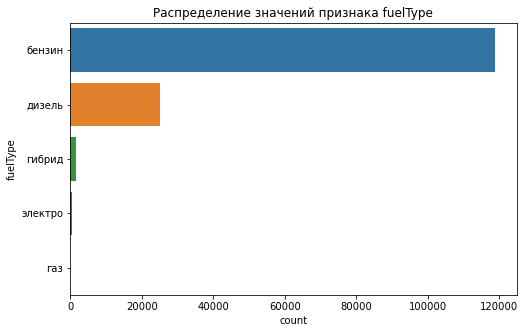

In [54]:
getCountPlot(data,'fuelType')

### modelDate

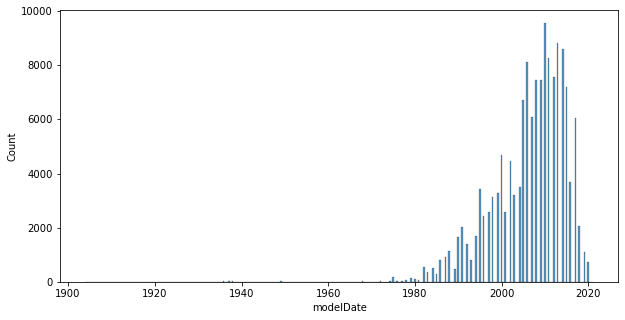

In [55]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="modelDate");

Больше всего в продаже 10-летних моделей

### numberOfDoors

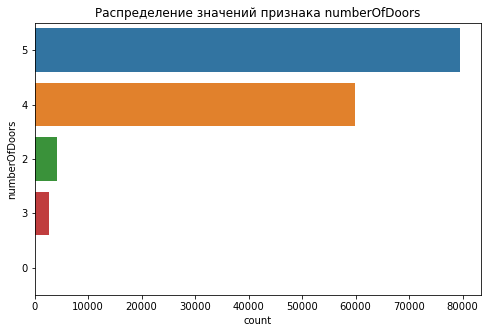

In [56]:
getCountPlot(data,'numberOfDoors')

у одного автомобиля указано 0 дверей

In [57]:
data[data['numberOfDoors'] == 0]

,bodyType,brand,car_url,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль,Состояние,price,sample,description_len
128553,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,5.3,32,бензин,48000,1904,SIMPLEX,...,механическая,EUROPEAN,1 владелец,Оригинал,задний,Правый,Не требует ремонта,NaN,0,6.666957


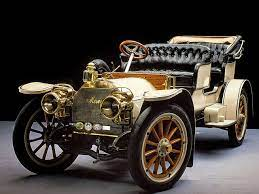

Вот такой, действительно - без окон, без дверей.

### productionDate

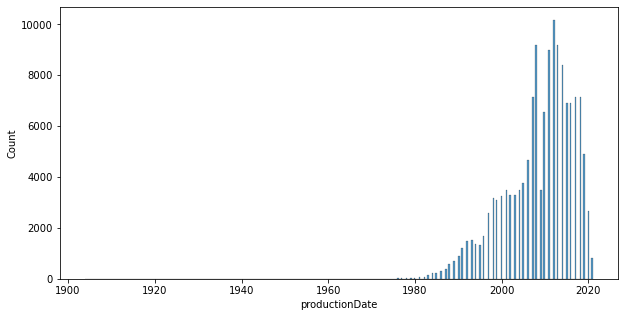

In [58]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data, x="productionDate");

Почти копия modelDate

Вероятно будут сильно коррелировать - под наблюдение

### vehicleTransmission

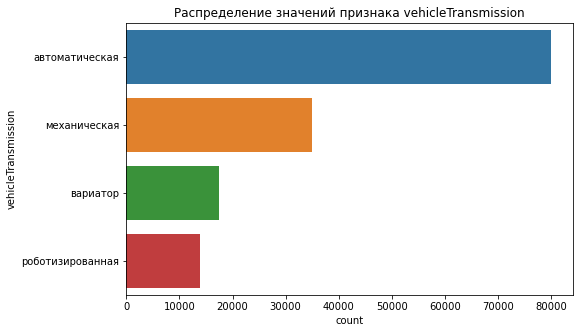

In [59]:
getCountPlot(data,'vehicleTransmission')

### super_gen - удалить

In [60]:
# Очень много уникальных наименований
data['super_gen'].nunique()

16813

In [61]:
# посмотрим на состав
data['super_gen'].value_counts()[:2]

{'id': '6214876', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'MECHANICAL', 'power': 105, 'power_kvt': 77, 'human_name': '1.6 MT (105 л.с.)', 'acceleration': 10.5, 'clearance_min': 170, 'fuel_rate': 6.5}    683
{'id': '20726520', 'displacement': 1598, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'AUTOMATIC', 'power': 110, 'power_kvt': 81, 'human_name': '1.6 AT (110 л.с.)', 'acceleration': 11.7, 'clearance_min': 163, 'fuel_rate': 5.9}    665
Name: super_gen, dtype: int64

Строки содержат как минимум 3 интересных количественных признака:

* acceleration
* clearance_min
* fuel_rate

Возможно стоит попробовать их извлечь, пока удалим.

In [62]:
data.drop(['super_gen'], axis=1, inplace=True)

### vendor

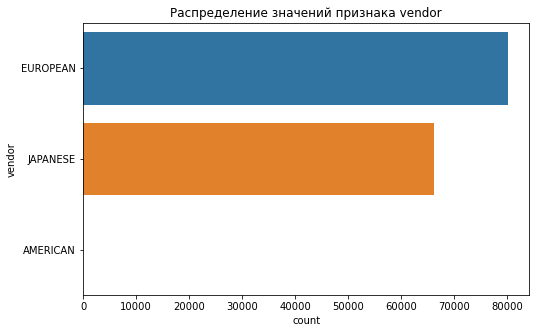

In [63]:
getCountPlot(data,'vendor')

Очень мало автомобилей с америаканского рынка

### Владельцы

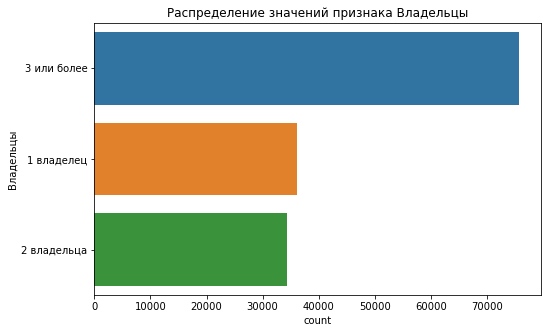

In [64]:
getCountPlot(data,'Владельцы')

### Привод

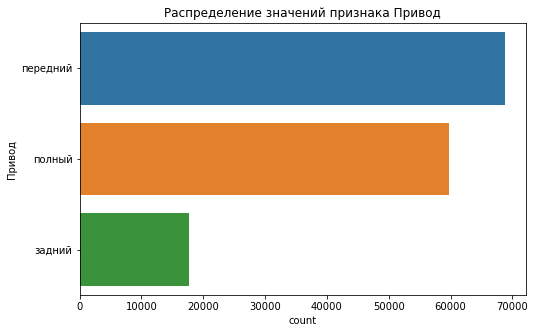

In [65]:
getCountPlot(data,'Привод')

### ПТС

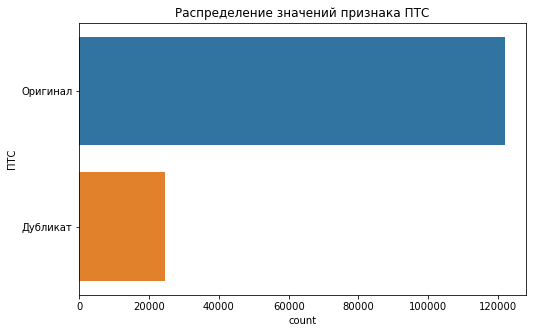

In [66]:
getCountPlot(data,'ПТС')

### Руль

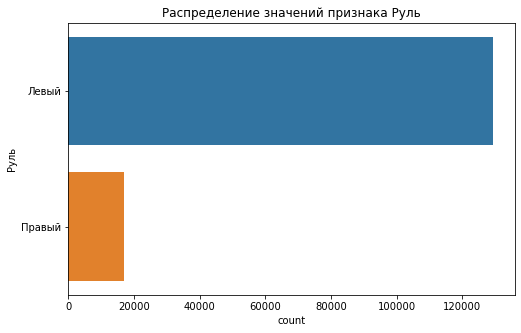

In [67]:
getCountPlot(data,'Руль')

### Состояние

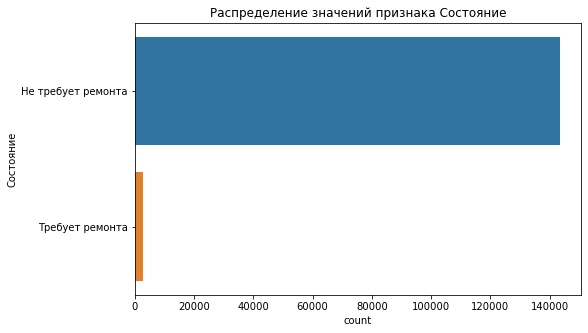

In [68]:
getCountPlot(data,'Состояние')

Крайне незначительное количество автомобилей, требующих ремонта

### mileage

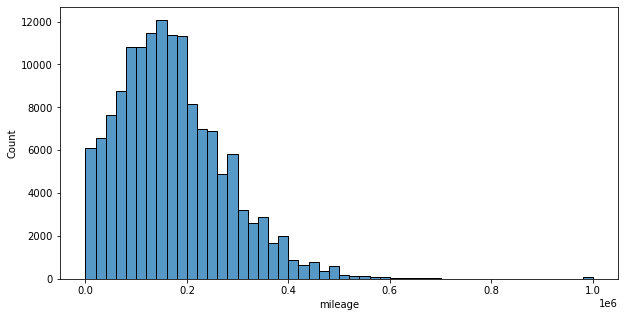

In [69]:
plt.figure(figsize=(10, 5))
sns.histplot(data=data['mileage'], bins=50);

Есть автомобили с пробегом под 1 млн. километров. Посмотрим на них

In [70]:
data[data['mileage']>999999].groupby(['brand', 'mileage','Состояние'])['sell_id'].count()

brand       mileage  Состояние         
AUDI        1000000  Не требует ремонта    3
BMW         1000000  Не требует ремонта    5
                     Требует ремонта       1
HONDA       1000000  Не требует ремонта    1
MERCEDES    1000000  Не требует ремонта    5
                     Требует ремонта       1
MITSUBISHI  1000000  Не требует ремонта    1
NISSAN      1000000  Не требует ремонта    3
                     Требует ремонта       1
TOYOTA      1000000  Не требует ремонта    7
                     Требует ремонта       2
VOLKSWAGEN  1000000  Не требует ремонта    6
                     Требует ремонта       1
VOLVO       1000000  Не требует ремонта    1
Name: sell_id, dtype: int64

Удивительно, конечно, что автомобиль с пробегом 1 млн килорметров "не требует ремонта", но проверка показала, что именно так и указано в объявлении, при том, что в описании часто перечислены значительные неисправности... 

И хотя пробег возможно и реальный, но лучше считать это выбросом и удалить. Таких значений не много.

Посмотрим на распределение признака внутри межквартильного размаха

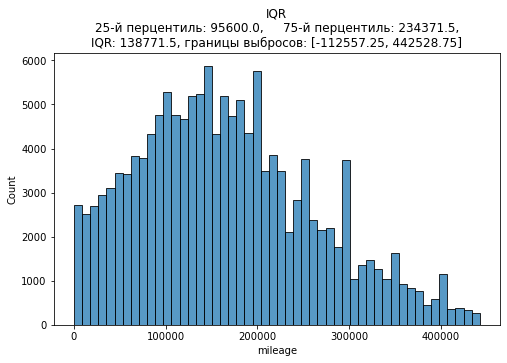

In [71]:
interquartile_range(data['mileage'], bins=50)

Распределение в целом нормальное.
Любопытны аномальные выбросы вблизи "круглых" значений пробега - 150, 200, 250, 300, 350, 400 тысяч километров.

Может свидетельствовать о наличии в этих группах определённой доли автомобилей с "нечестным" пробегом.

In [72]:
# зобработаем выбросы
q_1 = np.quantile(data['mileage'], 0.25) 
q_3 = np.quantile(data['mileage'], 0.75) 
IQR = q_3 - q_1
low = q_1 - IQR * 1.5 
high = q_3 + IQR * 1.5
data['mileage'] = data['mileage'].map(lambda x: replace_outliers(x, low, high))

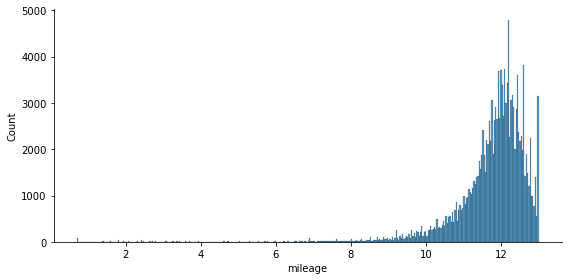

In [73]:
# логарифмируем
data['mileage'] = data['mileage'].apply(lambda w: np.log(w + 1))
sns.displot(data=data, x="mileage", height=4, aspect=2);

# Подготовка данных

In [74]:
# Категориальные признаки
cat_cols = ['bodyType','brand','color','fuelType','model_name','vehicleTransmission','vendor','Владельцы','Привод','numberOfDoors']
# бинарные
bin_cols = ['ПТС','Руль','Состояние']
# Количественные
nom_cols = ['enginePower','mileage','modelDate','productionDate','engineDisplacement','description_len']

In [75]:
data[nom_cols]

,enginePower,mileage,modelDate,productionDate,engineDisplacement,description_len
0,290,12.128117,2009,2011,3.0,5.874931
1,173,12.206078,2009,2012,3.0,6.714171
2,309,12.429220,2012,2012,4.6,6.190315
3,150,11.695255,2005,2006,2.0,4.343805
4,133,12.066816,2010,2012,1.8,5.049856
...,...,...,...,...,...,...
146290,136,11.652696,2011,2014,1.6,6.028279
146291,190,11.492733,2016,2018,2.0,3.433987
146292,170,12.793862,1995,1997,2.5,2.890372
146293,184,11.413116,2012,2013,2.0,6.391917


## Стандартизация

In [76]:
# Для экспериментов
scaler = StandardScaler()
df_nom = pd.DataFrame(scaler.fit_transform(data[nom_cols]),columns=nom_cols)
df_nom.sample(2)

,enginePower,mileage,modelDate,productionDate,engineDisplacement,description_len
27004,0.087513,-0.354183,0.786345,0.798826,-0.326191,-1.802577
143292,0.087513,-1.274712,1.146943,0.924041,-0.326191,-0.758567


## Нормализация

In [77]:
# scaler = MinMaxScaler()
# df_nom = pd.DataFrame(scaler.fit_transform(data[nom_cols]),columns=nom_cols)
# df_nom.sample(2)

In [78]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
#df_cat = pd.DataFrame()
#df_cat = OneHotEncoder(sparse=False).fit_transform(data[cat_cols].values)

#df_cat = pd.DataFrame(df_cat)

## Label Encoding

In [79]:
# Кодируем категориальные признаки
df_cat = pd.DataFrame()
for colum in cat_cols:
    df_cat[colum] = data[colum].astype('category').cat.codes
df_cat.sample(2)

,bodyType,brand,color,fuelType,model_name,vehicleTransmission,vendor,Владельцы,Привод,numberOfDoors
77504,24,2,1,0,388,1,2,0,1,4
120928,24,1,15,0,10,0,1,1,0,4


In [80]:
# Кодируем бинарные признаки
le = LabelEncoder()
df_bin = pd.DataFrame()
for col in bin_cols:
    le.fit(data[col])
    df_bin[col] = le.transform(data[col])
    
df_bin.sample(2)

,ПТС,Руль,Состояние
125243,1,0,0
87776,0,1,0


In [81]:
# Соединяем
df = pd.concat([df_nom, df_cat, df_bin], sort=False,axis=1)
df[['price','sample']] = data[['price','sample']].copy()

df.sample(2)

,enginePower,mileage,modelDate,productionDate,engineDisplacement,description_len,bodyType,brand,color,fuelType,...,vehicleTransmission,vendor,Владельцы,Привод,numberOfDoors,ПТС,Руль,Состояние,price,sample
95093,-0.847301,-0.127311,-0.535849,-0.703747,-0.872960,-2.957868,20,9,1,0,...,0,2,0,2,4,1,1,0,220000.0,1
6679,-1.083963,0.716604,-1.016646,-1.079391,-1.091668,-1.076858,4,7,15,0,...,0,2,1,1,4,1,1,0,130000.0,1


In [82]:
# # Создание полиномиальных признаков - не дало существенного прироста качества 
# lst = nom_cols + cat_cols
# pf = PolynomialFeatures(2)
# X_poly = pd.DataFrame(pf.fit_transform(df[lst]))
# df = pd.concat([df, X_poly], sort=False, axis=1)
# df.sample(2)

In [83]:
df.describe()

,enginePower,mileage,modelDate,productionDate,engineDisplacement,description_len,bodyType,brand,color,fuelType,...,vehicleTransmission,vendor,Владельцы,Привод,numberOfDoors,ПТС,Руль,Состояние,price,sample
count,1.462950e+05,1.462950e+05,1.462950e+05,1.462950e+05,1.462950e+05,1.462950e+05,146295.000000,146295.000000,146295.000000,146295.000000,...,146295.000000,146295.000000,146295.000000,146295.000000,146295.000000,146295.000000,146295.000000,146295.000000,1.116090e+05,146295.000000
mean,-1.267599e-14,-1.669809e-15,3.802555e-14,-3.203204e-15,3.377903e-14,2.419448e-15,10.081814,6.008968,9.454985,0.553348,...,0.881609,1.451806,1.270754,1.286975,3.467118,0.833159,0.115185,0.019796,1.224350e+06,0.762904
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,7.752056,3.400402,5.459598,1.159388,...,1.072340,0.497715,0.831561,0.669069,0.676802,0.372835,0.319246,0.139298,1.457432e+06,0.425303
min,-2.006944e+00,-1.079731e+01,-1.231539e+01,-1.309998e+01,-2.513269e+00,-4.211315e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.200000e+04,0.000000
25%,-7.171369e-01,-2.953485e-01,-5.358488e-01,-5.785328e-01,-7.636065e-01,-6.132668e-01,1.000000,3.000000,4.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,0.000000,0.000000,3.800000e+05,1.000000
50%,-2.911456e-01,2.066080e-01,1.853476e-01,2.979684e-01,-3.261908e-01,6.129929e-02,15.000000,7.000000,12.000000,0.000000,...,0.000000,1.000000,2.000000,1.000000,4.000000,1.000000,0.000000,0.000000,7.900000e+05,1.000000
75%,4.070067e-01,5.786738e-01,7.863446e-01,6.736118e-01,5.486406e-01,7.941758e-01,15.000000,9.000000,15.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,4.000000,1.000000,0.000000,0.000000,1.549000e+06,1.000000
max,5.601733e+00,1.198176e+00,1.747940e+00,1.550113e+00,4.704090e+00,1.459882e+00,24.000000,11.000000,15.000000,4.000000,...,3.000000,2.000000,2.000000,2.000000,4.000000,1.000000,1.000000,1.000000,6.500000e+07,1.000000


## ИТОГИ ПРЕДОБРАБОТКИ

## Значение номинативных признаков

In [84]:
#from sklearn.feature_selection import f_regression
#result = df[df['sample'] == 1].copy()
#result = pd.Series(f_regression(result[nom_cols], result['price'])[0], index=[nom_cols][0])
#result.sort_values(inplace=True)
#result.plot(kind='barh');

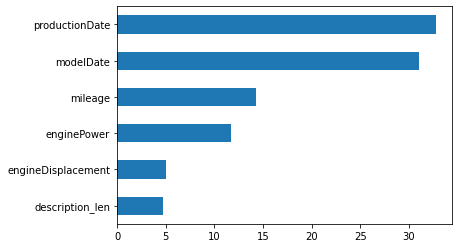

In [85]:
result = df[df['sample'] == 1].copy()
result = pd.Series(f_classif(result[nom_cols], result['price'])[0], index=[nom_cols][0])
result.sort_values(inplace=True)
result.plot(kind='barh');

Всё закономеро - цена сильно зависит от года и пробега

## Значение категориальных и бинарных признаков

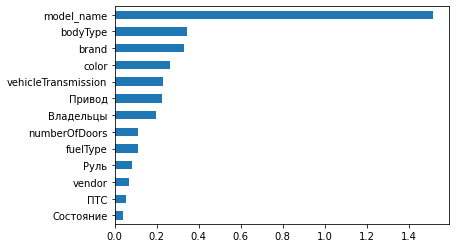

In [86]:
result = df[df['sample'] == 1].copy()
result = pd.Series(mutual_info_classif(result[cat_cols + bin_cols],result['price'],
    discrete_features=True), index=[cat_cols + bin_cols][0])
result.sort_values(inplace=True)
result.plot(kind='barh');

Построим общую корреляционную матрицу для всех обработанных признаков

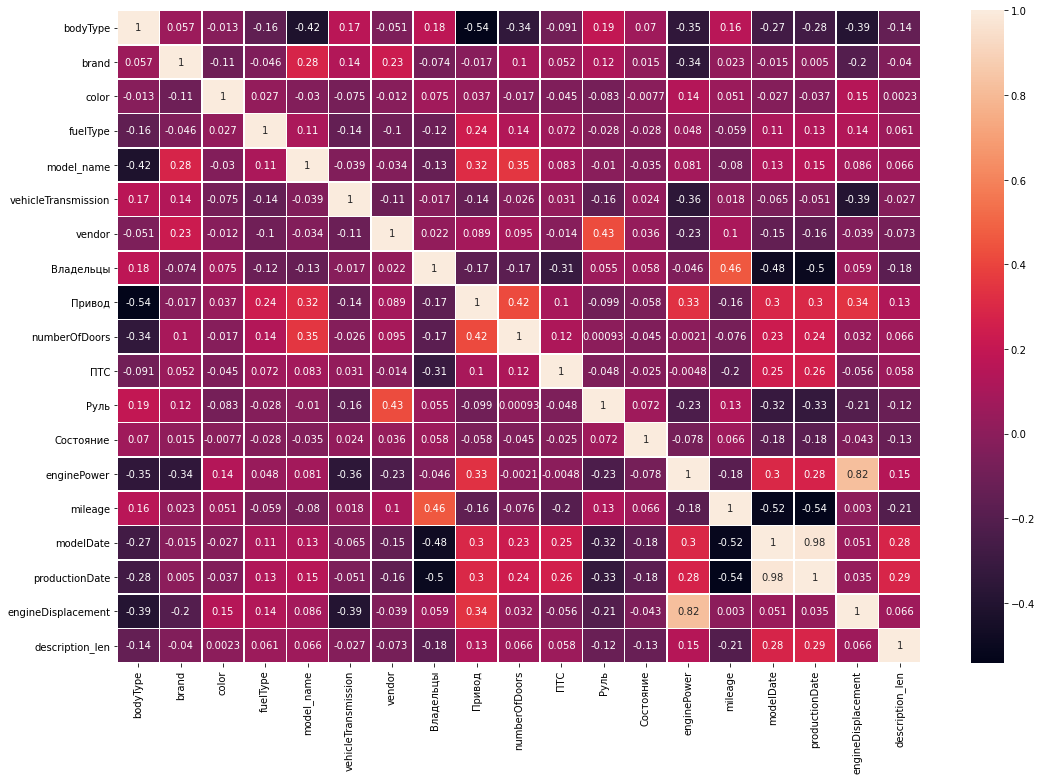

In [87]:
result = df[df['sample'] == 1].copy()
plt.figure(figsize=(18, 12))
sns.heatmap(result[cat_cols + bin_cols + nom_cols].corr(),annot=True, linewidths=.5);

Сильная корреляция между:

* modelDate - productionDate
* engineDisplacement - enginePower

Объединим признаки методом главных компонент

In [88]:
feature = {'periodOperation': ['modelDate', 'productionDate'],
           'engine': ['engineDisplacement', 'enginePower']}
for key in feature.keys():
    result = df[feature[key]].values

    # создаём экземпляр Scaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(result)

    # Указываем новую размерность - n_components
    pca = PCA(n_components=1)
    pca.fit(scaled_data)
    pca_data = pca.transform(scaled_data)
    
    # создаём новый признак
    df[key] = pca_data
    df = df.drop(feature[key],axis=1)

# Скорректируем количественные признаки
nom_cols = ['engine','mileage','numberOfDoors','periodOperation','description_len']

Смотрим на результат:

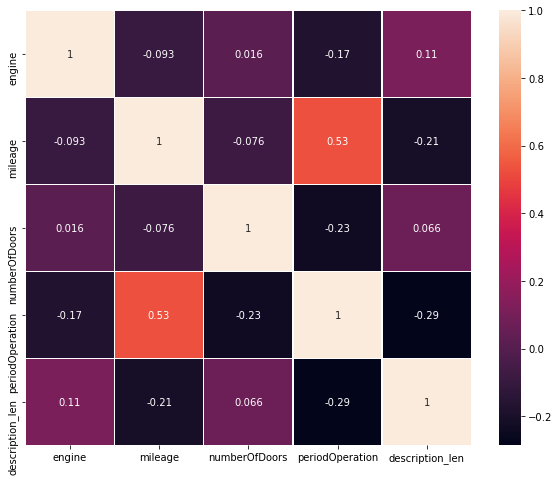

In [89]:
result = df[df['sample'] == 1].copy()
plt.figure(figsize=(10, 8))
sns.heatmap(result[nom_cols].corr(),annot=True, linewidths=.5);

Значительных корреляций нет

## Train Split

In [90]:
X = df.query('sample == 1').drop(['sample', 'price'], axis=1)
y = df.query('sample == 1')['price'] 
X_sub = df.query('sample == 0').drop(['sample', 'price'], axis=1)

display(f'y {y.shape}, train {X.shape}, test {X_sub.shape}')

'y (111609,), train (111609, 17), test (34686, 17)'

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Модели

In [92]:
def print_learn_report(start, y_test, y_pred):
    print('\nВремя выполнения - ', datetime.now() - start)
    print(f"Точность по метрике MAPE:{(mape(y_test, y_pred))*100:0.2f}%")

## Lazypredict

Определим наиболее подходящую модель

In [93]:
# # # Для проверки моделей используем 10% данных
# start = datetime.now()
# offset = int(X.shape[0] * 0.9)

# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]

# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mape)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# print(models)

```
                               Adjusted R-Squared  R-Squared       RMSE  \
Model                                                                     
XGBRegressor                                 0.91       0.91  595420.87   
LGBMRegressor                                0.89       0.89  652713.35   
ExtraTreesRegressor                          0.89       0.89  652832.40   
HistGradientBoostingRegressor                0.89       0.89  661996.65   
RandomForestRegressor                        0.88       0.88  694623.33   
BaggingRegressor                             0.88       0.88  706276.89   
ExtraTreeRegressor                           0.87       0.87  709650.79   
GradientBoostingRegressor                    0.86       0.86  755500.67   
DecisionTreeRegressor                        0.83       0.83  837041.05   
KNeighborsRegressor                          0.80       0.80  892743.07   
PoissonRegressor                             0.69       0.69 1110058.78   
MLPRegressor                                 0.57       0.57 1320252.33   
SGDRegressor                                 0.55       0.55 1345162.66   
LinearRegression                             0.54       0.54 1353922.44   
TransformedTargetRegressor                   0.54       0.54 1353922.44   
Lars                                         0.54       0.54 1353922.44   
Lasso                                        0.54       0.54 1353923.28   
Ridge                                        0.54       0.54 1353925.26   
RidgeCV                                      0.54       0.54 1353950.71   
LassoLarsIC                                  0.54       0.54 1353953.97   
BayesianRidge                                0.54       0.54 1353969.68   
LassoLars                                    0.54       0.54 1354190.36   
LassoLarsCV                                  0.54       0.54 1356595.90   
LarsCV                                       0.54       0.54 1356595.90   
LassoCV                                      0.54       0.54 1359422.11   
OrthogonalMatchingPursuitCV                  0.54       0.54 1365904.19   
ElasticNet                                   0.45       0.45 1480839.55   
GammaRegressor                               0.45       0.45 1482874.68   
HuberRegressor                               0.42       0.42 1527823.90   
PassiveAggressiveRegressor                   0.40       0.40 1550372.91   
RANSACRegressor                              0.40       0.40 1556466.78   
TweedieRegressor                             0.38       0.38 1573060.79   
GeneralizedLinearRegressor                   0.38       0.38 1573060.79   
OrthogonalMatchingPursuit                    0.21       0.22 1775880.52   
AdaBoostRegressor                            0.03       0.03 1974856.41   
ElasticNetCV                                -0.21      -0.21 2204529.43   
DummyRegressor                              -0.21      -0.21 2207947.67   
NuSVR                                       -0.34      -0.34 2319552.19   
SVR                                         -0.44      -0.43 2401142.85   
LinearSVR                                   -0.94      -0.93 2788813.23   

                               Time Taken  mape  
Model                                            
XGBRegressor                         7.22  0.11  
LGBMRegressor                        0.98  0.13  
ExtraTreesRegressor                 56.95  0.11  
HistGradientBoostingRegressor        3.08  0.13  
RandomForestRegressor               75.03  0.11  
BaggingRegressor                     8.00  0.11  
ExtraTreeRegressor                   0.70  0.15  
GradientBoostingRegressor           19.16  0.16  
DecisionTreeRegressor                1.33  0.15  
KNeighborsRegressor                 16.36  0.19  
PoissonRegressor                     0.55  0.26  
MLPRegressor                       268.04  0.43  
SGDRegressor                         0.64  0.40  
LinearRegression                     0.23  0.39  
TransformedTargetRegressor           0.22  0.39  
Lars                                 0.21  0.39  
Lasso                                0.32  0.39  
Ridge                                0.21  0.39  
RidgeCV                              0.38  0.39  
LassoLarsIC                          0.25  0.39  
BayesianRidge                        0.27  0.39  
LassoLars                            0.21  0.39  
LassoLarsCV                          1.00  0.39  
LarsCV                               0.97  0.39  
LassoCV                              1.19  0.39  
OrthogonalMatchingPursuitCV          0.65  0.39  
ElasticNet                           0.24  0.39  
GammaRegressor                       0.36  0.35  
HuberRegressor                       0.91  0.34  
PassiveAggressiveRegressor           2.76  0.34  
RANSACRegressor                      0.83  0.36  
TweedieRegressor                     0.26  0.41  
GeneralizedLinearRegressor           0.31  0.41  
OrthogonalMatchingPursuit            0.18  0.56  
AdaBoostRegressor                   11.24  1.84  
ElasticNetCV                         1.09  0.69  
DummyRegressor                       0.15  0.69  
NuSVR                             1098.75  0.62  
SVR                               1887.86  0.61  
LinearSVR                            0.31  0.90 
```

## Lazypredict - модели с лучшей метрикой MAPE

Model|Time Taken | mape
:-|-:|-:                                      
XGBRegressor|                         7.22|  0.11   
ExtraTreesRegressor|                 56.95 | 0.11   
RandomForestRegressor         |      75.03 | 0.11  
BaggingRegressor               |      8.00 | 0.11 



Самые быстрые XGBRegressor и BaggingRegressor

Но проверим еще некоторые модели

##  CatBoost

In [94]:
# start = datetime.now()

# model = CatBoostRegressor(iterations = 5000,
#                           cat_features=cat_cols,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          use_best_model=True,
#          verbose=False,
#          plot=True
#          )

# model.save_model('catboost_model.model')

# predict = model.predict(X_test)
# print_learn_report(start, y_test, predict)

CatBoost

1. iterations = 50
   * Время выполнения -  0:00:09.447007
   * Точность по метрике MAPE:24.08%
   
   
2. iterations = 500
   * Время выполнения -  0:02:03.490157
   * Точность по метрике MAPE:19.13%
   
3. iterations = 5000
   * Время выполнения -  0:23:52.186108
   * Точность по метрике MAPE:17.65%

## Log Traget

Логарифмирование целевой переменной и подбор наилучших параметров

Попробуем взять таргет в логарифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).

In [95]:
# start = datetime.now()



# model = CatBoostRegressor(cat_features=cat_cols, iterations=5000
#                           ,loss_function='MAPE', metric_period=10)

# grid = {'learning_rate': [ 0.01, 0.1, 1]
#         ,'depth': [3, 5, 7]
#         ,'l2_leaf_reg': [7, 7.5, 8]
#         }

# grid_search_result = model.grid_search(grid
#                                     ,X=X_train
#                                     ,y=np.log(y_train)
#                                     ,plot=True
#                                     ,verbose=False)
# print('\nВремя выполнения - ', datetime.now() - start)
# print('\nНаилучшие параметры: ', grid_search_result['params'])


# Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 7.5, 'random_strength': 0.3, 'learning_rate': 0.15}
# Наилучшие параметры:  {'depth': 12, 'l2_leaf_reg': 8, 'random_strength': 0.3, 'learning_rate': 0.15}

# cb = CatBoostRegressor(iterations = 5000,
#                        random_seed = RANDOM_SEED,
#                        eval_metric='MAPE',
#                        custom_metric=['R2', 'MAE'],
#                        silent=True,
#                        learning_rate=0.15, depth=12,
#                        l2_leaf_reg=7.5, random_strength=0.3)

# cb.fit(X_train, np.log(y_train),
#         eval_set=(X_test, np.log(y_test)),
#         verbose=False,
#         use_best_model=True,
#         plot=True)

# cb.save_model('catboost_log_model.model')

# predict_test = np.exp(cb.predict(X_test))
# print_learn_report(start, y_test, predict_test)

## Random Forest

In [96]:
start = datetime.now()

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4],
#                'bootstrap': [True, False]}

# rfr = RandomForestRegressor(random_state = RANDOM_SEED)
# rf_random = RandomizedSearchCV(estimator = rfr, 
#                                param_distributions = random_grid, 
#                                n_iter = 100, cv = 3, verbose=10, 
#                                random_state=RANDOM_SEED, n_jobs = -1)
# rf_random.fit(X_train, np.log(y_train))
# rf_random.best_params_

# best_params_: 
# {'n_estimators': 300,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': False}

# best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED,
                                 n_estimators=300,
                                 min_samples_split=10,
                                 min_samples_leaf=1,
                                 max_features='sqrt',
                                 max_depth=None,
                                 bootstrap=False)

best_rfr.fit(X_train, np.log(y_train))


predict_rfr = np.exp(best_rfr.predict(X_test))
print_learn_report(start, y_test, predict_rfr)


Время выполнения -  0:00:58.485131
Точность по метрике MAPE:15.40%


* Время выполнения -  0:00:58.485131
* Точность по метрике MAPE:15.40%

## Gradient Boosting Regressor

In [97]:
start = datetime.now()

# random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 400, num = 8)],
#                'max_features': ['auto', 'sqrt', 'log2'],
#                'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
#                'min_samples_split': [2, 5, 10],
#                'min_samples_leaf': [1, 2, 4]}

# gbr = GradientBoostingRegressor()
# gbr_random = RandomizedSearchCV(estimator = gbr, 
#                                 param_distributions = random_grid, 
#                                 n_iter = 100, 
#                                 cv = 3, 
#                                 verbose=10, 
#                                 random_state=RANDOM_SEED,
#                                 n_jobs = -1)

# gbr_random.fit(X_train, np.log(y_train))
# gbr_random.best_params_

best_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED,
                                     n_estimators=750,
                                     min_samples_split=2,
                                     min_samples_leaf=4,
                                     max_features='auto',
                                     max_depth=7)

best_gbr.fit(X_train, np.log(y_train))

predict_gbr = np.exp(best_gbr.predict(X_test))
print_learn_report(start, y_test, predict_gbr)


Время выполнения -  0:03:51.436140
Точность по метрике MAPE:15.26%


* Время выполнения -  0:03:51.436140
* Точность по метрике MAPE:15.26%

## XGB Regressor

In [98]:
start = datetime.now()

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=7, alpha=1,
                          n_estimators=1000)
xgb_reg.fit(X_train, np.log(y_train))
xgb_red_pred = np.exp(xgb_reg.predict(X_test))
print_learn_report(start, y_test, xgb_red_pred)


Время выполнения -  0:00:20.411392
Точность по метрике MAPE:15.06%


* Время выполнения -  0:00:20.411392
* Точность по метрике MAPE:15.06%

## BaggingRegressor

###  + Random Forest

In [99]:
start = datetime.now()

bagg_rfr = BaggingRegressor(best_rfr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_rfr.fit(X_train, np.log(y_train))
predict_bagg_rfr = np.exp(bagg_rfr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_rfr)


Время выполнения -  0:01:52.865535
Точность по метрике MAPE:15.65%


* Время выполнения -  0:01:52.865535
* Точность по метрике MAPE:15.65%

###  + Gradient Boosting Regressor

In [100]:
start = datetime.now()

bagg_gbr = BaggingRegressor(best_gbr, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_gbr.fit(X_train, np.log(y_train))
predict_bagg_gbr = np.exp(bagg_gbr.predict(X_test))
print_learn_report(start, y_test, predict_bagg_gbr)


Время выполнения -  0:08:53.981971
Точность по метрике MAPE:15.18%


* Время выполнения -  0:08:53.981971
* Точность по метрике MAPE:15.18%

### + XGB Regressor

In [101]:
start = datetime.now()

bagg_xgb = BaggingRegressor(xgb_reg, n_estimators=3, n_jobs=1, random_state=RANDOM_SEED)
bagg_xgb.fit(X_train, np.log(y_train))
predict_bagg_xgb = np.exp(bagg_xgb.predict(X_test))
print_learn_report(start, y_test, predict_bagg_xgb)


Время выполнения -  0:01:23.170178
Точность по метрике MAPE:15.12%


* Время выполнения -  0:01:23.170178
* Точность по метрике MAPE:15.12%

#### BaggingRegressor + (результаты в порядке убывания качества):

1. XGB Regressor: : результат улучшен (лучший из всех)
2. Gradient Boosting Regressor: результат улучшен
3. Random Forest: результат ухудшился

# Стекинг

In [102]:
# для композиции выберем базовые регрессоры
estimators = [ ('bagg_rfr', bagg_rfr),
              ('gbr', best_gbr),
              ('rfr', best_rfr)]
# для итогового - регрессор с лучшей итоговой метрикой
final_estimator = bagg_xgb

reg = StackingRegressor(
     estimators=estimators,
     final_estimator=final_estimator)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f'MAPE = {mape(y_test, y_pred)*100}%')

MAPE = 16.876187371145086%


Время выполнения -  0:18:28.895312
Точность по метрике MAPE:15.26%

* Стекинг с настроенными базовыми моделями и с моделями по умолчанию не показал существенных отличий